In [1]:
import pints
import pints.toy

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils

import numpy as np
import matplotlib.pyplot as plt
import GPy

import string
from itertools import product

## Specifying model

In [2]:
# Create a model
model = pints.toy.GoodwinOscillatorModel()

n_parameters = model.n_parameters()
n_outputs = model.n_outputs()
real_parameters = model.suggested_parameters()

values, times, noise_stds = emutils.simulate(model,
                                             parameters=real_parameters
                                            )

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
real_log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise_stds)

print("Number of parameters: ", n_parameters)
print("Parameter values: ", real_parameters)
print("Example problem values:\n", problem.values()[:5])

Number of parameters:  5
Parameter values:  [2.   4.   0.12 0.08 0.1 ]
Example problem values:
 [[0.0054139  0.05761261 1.91823359]
 [0.00600192 0.06665862 1.98921633]
 [0.00614325 0.0804155  2.17654291]
 [0.00475994 0.08826114 2.3480015 ]
 [0.00394262 0.09811605 2.67516305]]


In [3]:
# specify names for each parameter in the model
# default is alphabetical
index_to_param_name = dict(enumerate(string.ascii_lowercase[:n_parameters]))
index_to_param_name

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e'}

## Creating emulator and specifying variables

In [4]:
# creating distribution on bounds
# by default uniform with +-10% of original values
param_range = 0.1
real_params_lower = (1 - param_range) * real_parameters
real_params_upper = (1 + param_range) * real_parameters

bounds = pints.Boundaries(lower = real_params_lower, upper = real_params_upper)
log_prior = pints.UniformLogPrior(bounds)

print(list(zip(bounds.lower(), bounds.upper())))

[(1.8, 2.2), (3.6, 4.4), (0.108, 0.132), (0.07200000000000001, 0.08800000000000001), (0.09000000000000001, 0.11000000000000001)]


In [5]:
# training size
training_size = 500

input_parameters = log_prior.sample(training_size)
target_likelihoods = np.apply_along_axis(real_log_likelihood, 1, input_parameters)

emu = emupints.GPEmulator(real_log_likelihood, 
                          input_parameters, 
                          target_likelihoods, 
                          normalize_input = True)

## Visualizing fixed surfaces 

In [6]:
# number of splits for each free parameter
axis_n_splits = 50
# take min, median, and max values to fix parameter
fixed_param_splits = 3

fixed_parameters = []

# fixed values for each of three parameters
#
for i in range(n_parameters):
    for j in range(n_parameters):
        if i == j:
            continue
        mid_vals = enumerate( (bounds.lower()+bounds.upper())/2 )
        mid_vals = list(mid_vals)
        mid_vals = [(idx, val) for (idx, val) in mid_vals if idx not in [i, j]] 

        fixed_parameters.append(mid_vals)


fixed_parameters

[[(2, 0.12), (3, 0.08000000000000002), (4, 0.1)],
 [(1, 4.0), (3, 0.08000000000000002), (4, 0.1)],
 [(1, 4.0), (2, 0.12), (4, 0.1)],
 [(1, 4.0), (2, 0.12), (3, 0.08000000000000002)],
 [(2, 0.12), (3, 0.08000000000000002), (4, 0.1)],
 [(0, 2.0), (3, 0.08000000000000002), (4, 0.1)],
 [(0, 2.0), (2, 0.12), (4, 0.1)],
 [(0, 2.0), (2, 0.12), (3, 0.08000000000000002)],
 [(1, 4.0), (3, 0.08000000000000002), (4, 0.1)],
 [(0, 2.0), (3, 0.08000000000000002), (4, 0.1)],
 [(0, 2.0), (1, 4.0), (4, 0.1)],
 [(0, 2.0), (1, 4.0), (3, 0.08000000000000002)],
 [(1, 4.0), (2, 0.12), (4, 0.1)],
 [(0, 2.0), (2, 0.12), (4, 0.1)],
 [(0, 2.0), (1, 4.0), (4, 0.1)],
 [(0, 2.0), (1, 4.0), (2, 0.12)],
 [(1, 4.0), (2, 0.12), (3, 0.08000000000000002)],
 [(0, 2.0), (2, 0.12), (3, 0.08000000000000002)],
 [(0, 2.0), (1, 4.0), (3, 0.08000000000000002)],
 [(0, 2.0), (1, 4.0), (2, 0.12)]]

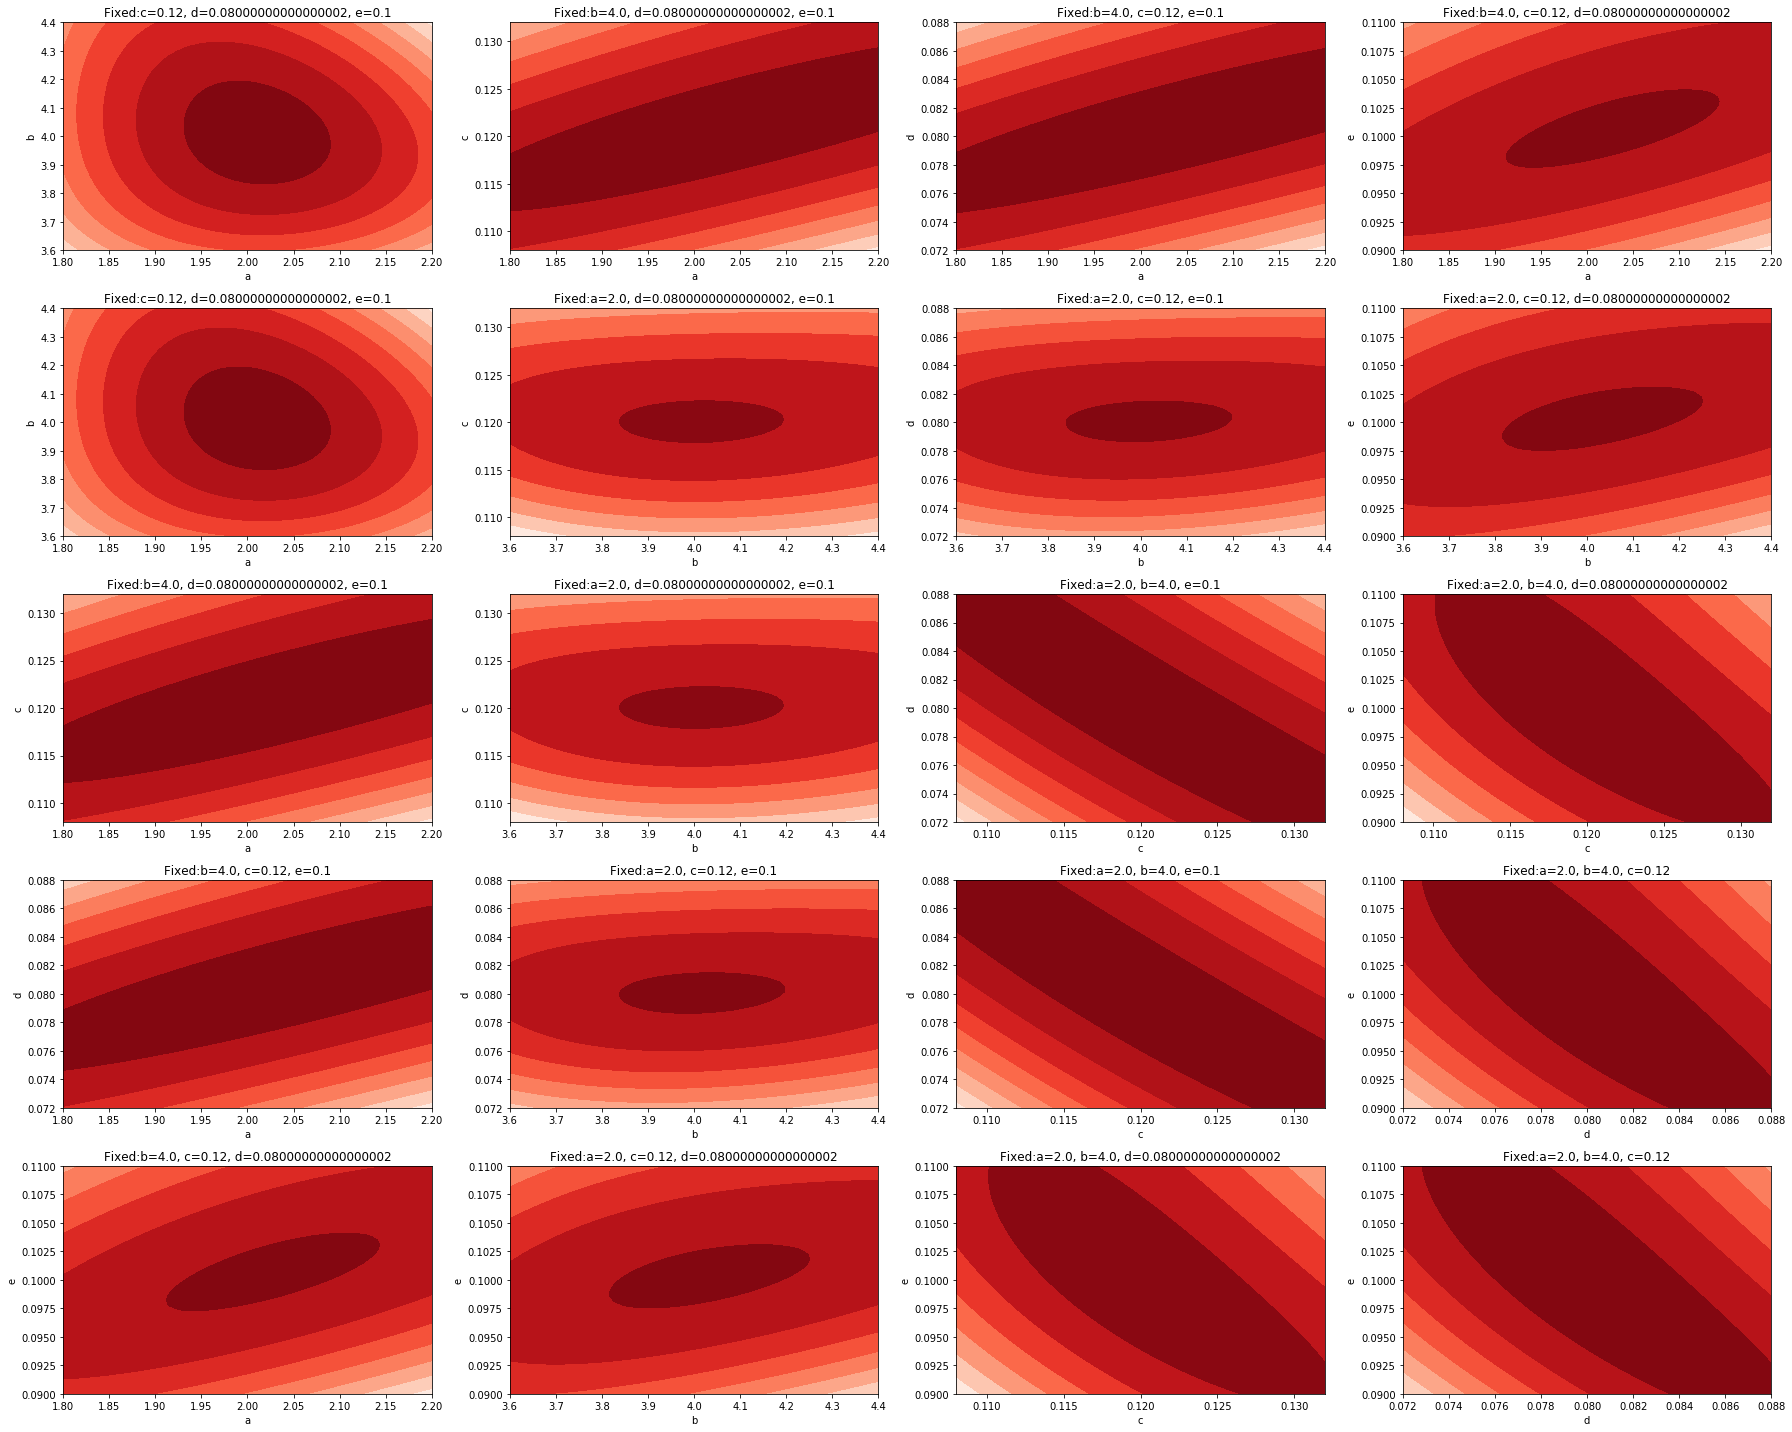

In [7]:
# row i has parameter i varying with every other parameter in the model
# however, x-axis is always taken by parameter that comes first in order
# i.e. lower index
fig, ax = emuplt.plot_fixed_param_grid(
    real_log_likelihood,
    fixed_parameters,
    bounds,
    n_splits = axis_n_splits,
    shape = (n_parameters, n_parameters - 1),
)

plt.show(fig)

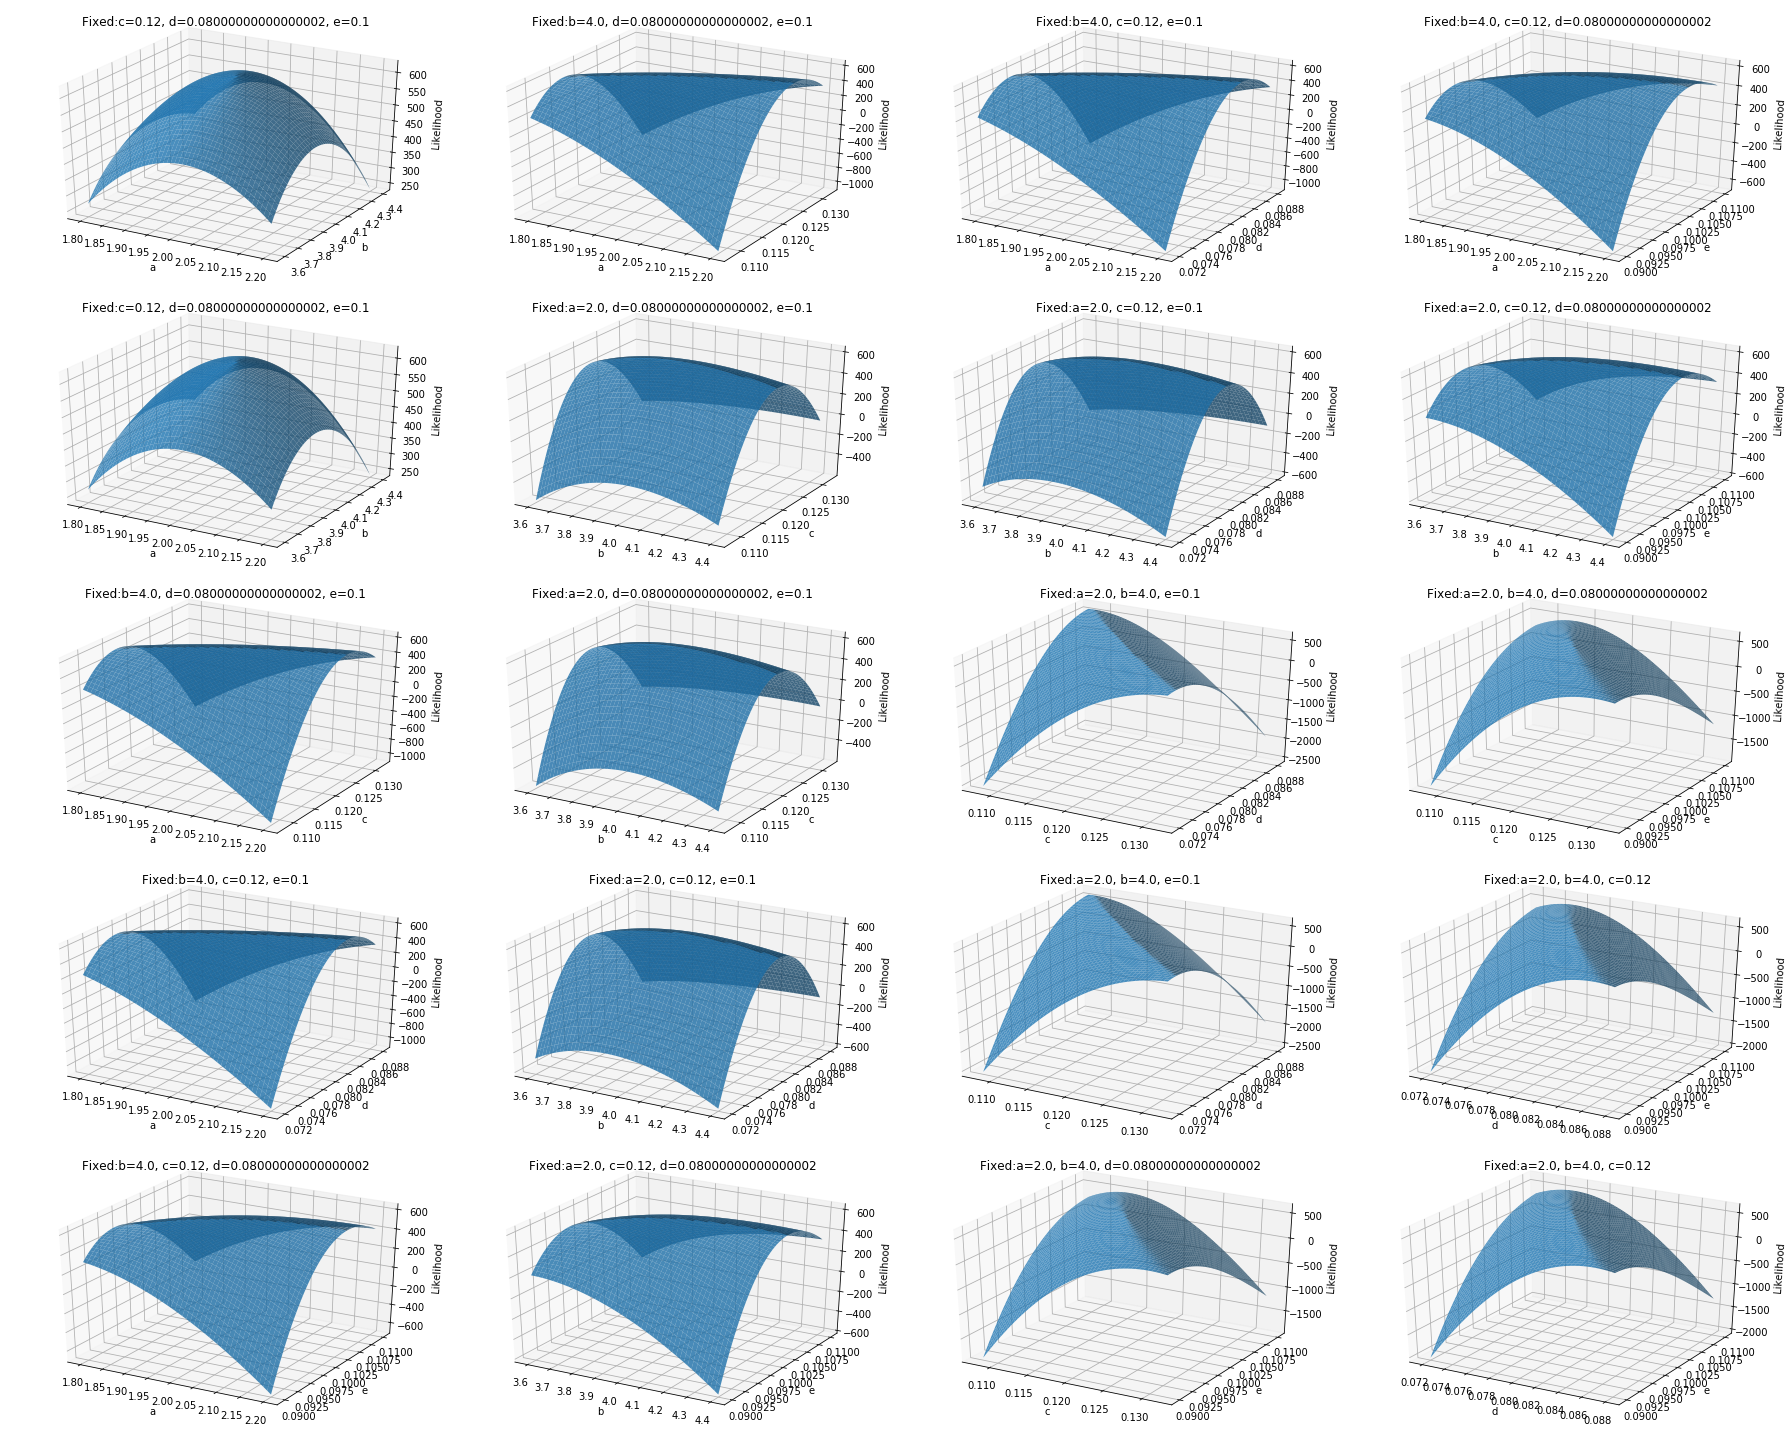

In [8]:
fig, ax = emuplt.plot_fixed_param_grid(
    real_log_likelihood,
    fixed_parameters,
    bounds,
    n_splits = axis_n_splits,
    shape = (n_parameters, n_parameters - 1),
    countour = False
)

plt.show(fig)

## Kernel selection

In [9]:
n_parameters = emu.n_parameters()
kernels = [
    GPy.kern.Linear(n_parameters),
    GPy.kern.Linear(n_parameters) * GPy.kern.Linear(n_parameters),
    GPy.kern.RBF(n_parameters, variance = 0.1),
    GPy.kern.RatQuad(n_parameters, variance = 0.1),
    GPy.kern.MLP(n_parameters),
    GPy.kern.Matern52(n_parameters),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) * GPy.kern.RBF(n_parameters)
]

kern_names = [
    "Linear",
    "Linear * Linear"
    "RBF",
    "RatQuad",
    "MLP",
    "Matern52",
    "RatQuad + RBF*RBF",
]

# kernels that have been optimized for input data
trained_kernels = []

# possible optimizers: 
# ‘scg’, ‘lbfgs’, ‘tnc’
# can specify max number of iterations using max_iters
optimizer = "lbfgs"
max_iters = 500
emu.set_parameters(optimizer = optimizer)

In [10]:
# when the output data is normalized values of variance should be small
# hence ignore any kernel that has a subkernel 
# (i.e kernel that is a part of sum/product) 
# with variance > 10000
# set avoid_overfitting to False to stop this effect
avoid_overfitting = True
variance_threshold = 10000

In [11]:
marginal_likelihoods = []

for kernel, kernel_name in zip(kernels, kern_names):
    emu.set_parameters(kernel = kernel)
    emu.fit(optimize = False, normalizer = True)
    emu.optimize(max_iters = max_iters, messages = False)
    
    trained_kernel = emu.get_trained_kern()
    trained_kernels.append(trained_kernel)
    
    ml = emu.get_log_marginal_likelihood()
    marginal_likelihoods.append(ml)
    print("{}: {:.2f}".format(kernel_name, ml))

Linear: -689.07
Linear * LinearRBF: -364.75
RatQuad: 1642.31
MLP: 1754.64
Matern52: 1754.17
RatQuad + RBF*RBF: 1272.59


In [12]:
trained_kernels[2]

In [13]:
best_kernel = None
best_score = -1 << 31

# find kernel with highest log marginal likelihood
for kernel, score in zip(trained_kernels, marginal_likelihoods):
    # ignore any overfitting kernel
    if avoid_overfitting and emutils.has_high_variance(kernel, threshold = variance_threshold):
        continue
    if score > best_score:
        best_kernel = kernel
        score = best_score
        
best_kernel

In [14]:
# when a kernel consists of many additions / multiplications
# utils method kernel_to_string can be useful
print(emutils.kernel_to_string(best_kernel))

MLP(5196.657093,0.031518,1957.504872)


In [15]:
# TODO: directly assign kernel to GP in class
emu.set_parameters(kernel = best_kernel)
emu.fit(optimize = False, normalizer = True)
emu.optimize(max_iters = max_iters, messages = False)

 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


 /Users/maksympetyak/Prog/emupints/emupints/_gp_emulator.py:59: UserWarning:Non-negative log_likelihood predicted.Indicative of high uncertainty in predictions.


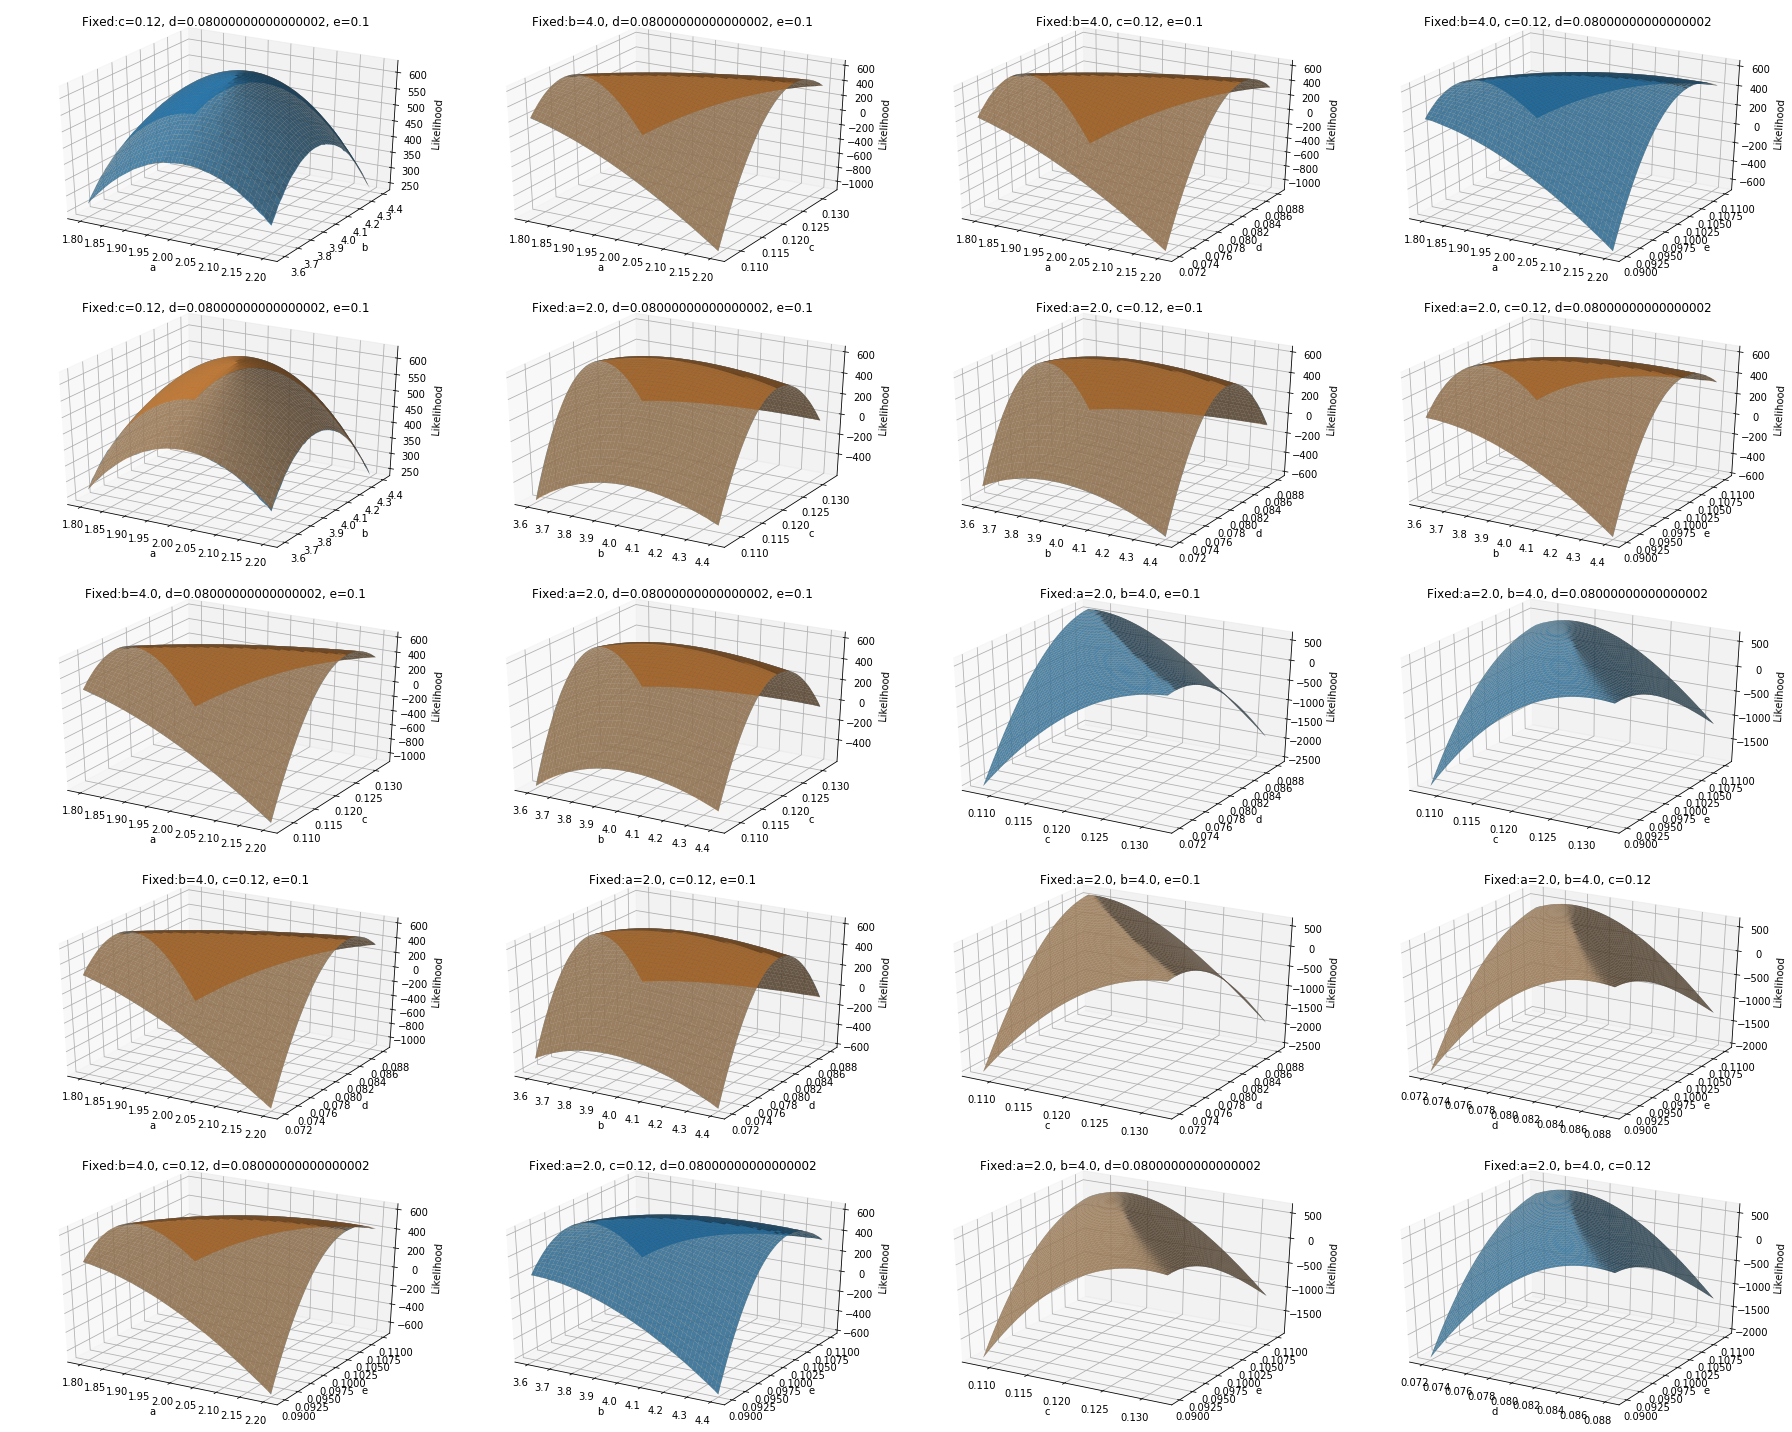

In [16]:
fig, ax = emuplt.plot_fixed_param_grid(
    emu,
    fixed_parameters,
    bounds,
    n_splits = axis_n_splits,
    shape = (n_parameters, n_parameters - 1),
    countour = False,
    additional_log_likelihoods = [real_log_likelihood]
)

plt.show(fig)

## Running and Timing MCMC

In [17]:
# MCMC parameters
mcmc_method = pints.PopulationMCMC
num_chains = 3
mcmc_max_iters = 20000

In [18]:
emu_posterior = pints.LogPosterior(emu, log_prior)
model_posterior = pints.LogPosterior(real_log_likelihood, log_prior)

In [19]:
# possible parameter starting points
# use three chains

xs = [
    real_parameters * 0.95,
    real_parameters * 0.90,
    real_parameters * 1.05,
]

In [20]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior, num_chains, xs, method = mcmc_method)
emu_mcmc.set_max_iterations(mcmc_max_iters)
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...


 /Users/maksympetyak/Prog/emupints/emupints/_gp_emulator.py:59: UserWarning:Non-negative log_likelihood predicted.Indicative of high uncertainty in predictions.


Done!
CPU times: user 47.7 s, sys: 201 ms, total: 47.9 s
Wall time: 48.1 s


In [21]:
%%time
# population MCMC
model_mcmc = pints.MCMCSampling(model_posterior, num_chains, xs, method = mcmc_method)
model_mcmc.set_max_iterations(20000)
model_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
model_chains = model_mcmc.run()
print('Done!')

Running...
Done!
CPU times: user 1min 49s, sys: 412 ms, total: 1min 49s
Wall time: 1min 49s


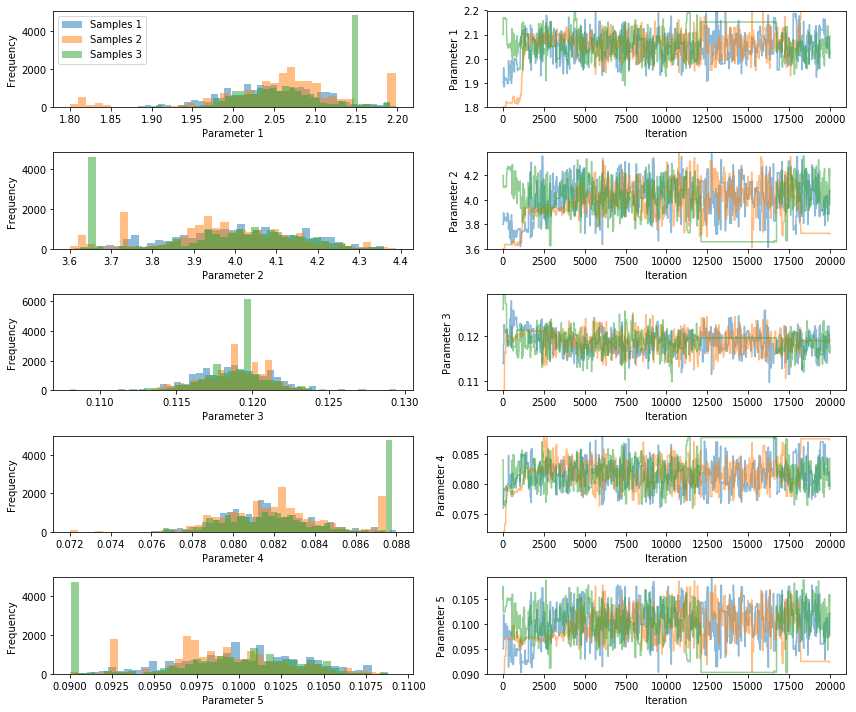

In [22]:
import pints.plot
pints.plot.trace(emu_chains)
plt.show()

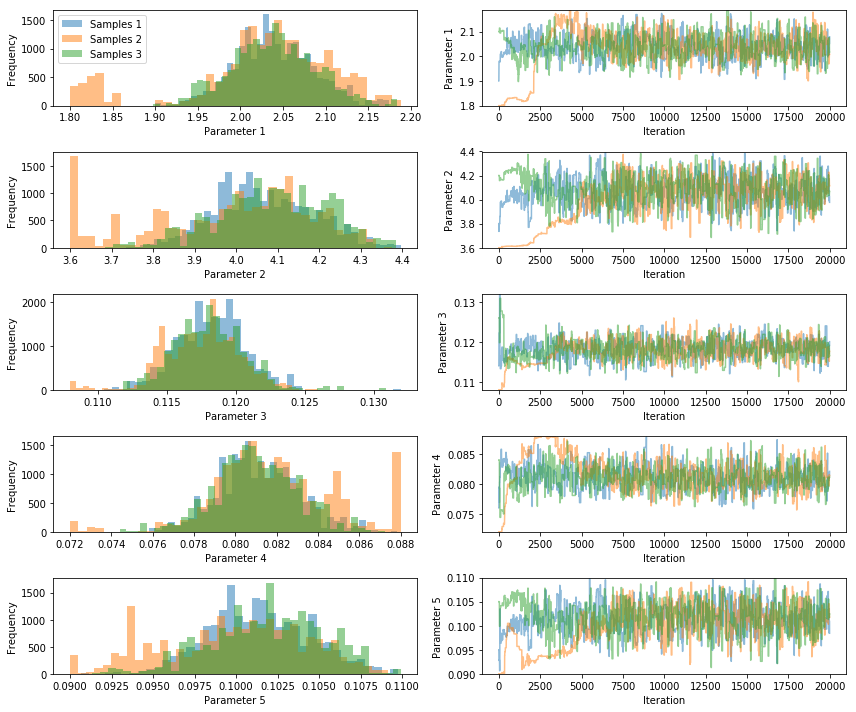

In [23]:
pints.plot.trace(model_chains)
plt.show()

In [24]:
# Look at likelihood changes along one chain
chain = emu_chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()

 /Users/maksympetyak/Prog/emupints/emupints/_gp_emulator.py:59: UserWarning:Non-negative log_likelihood predicted.Indicative of high uncertainty in predictions.


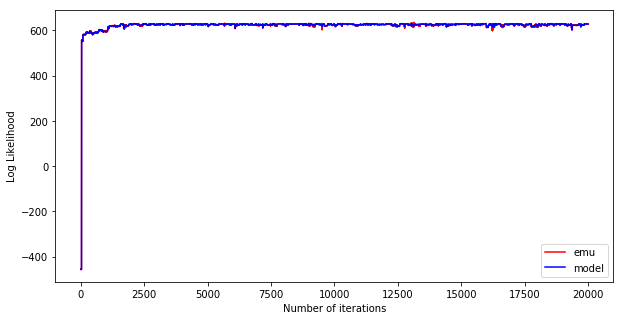

In [25]:
iters = range(len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color="Red", label='emu')
plt.plot(iters, model_prediction, color="Blue", label='model')
plt.legend()
plt.show()

In [26]:
diffs = np.abs(model_prediction - emu_prediction)

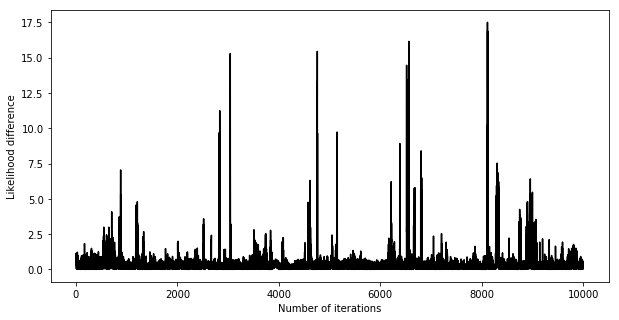

In [27]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood difference")
plt.plot(iters, diffs, color = "Black")
plt.show()